## About Tabular Playground Series - Oct 2021

The dataset used for this competition is synthetic, but based on a real dataset and generated using a CTGAN.

The dataset deals with predicting the biological response of molecules given various chemical properties. Although the features are anonymized, they have properties relating to real-world features.

## Previous notebooks

My first notebook on this competition explored the data in detail. At this point that notebook has had 38 upvotes and 15 comments, so might be worth a look before moving on to look at this notebook if you have not yet explored the data fully.
https://www.kaggle.com/davidcoxon/first-look-at-october-data

## About this notebook

This notebook is a work in progress and will be regularly updated. It is my second notebook of this competition and will concentrate on evaluating the performance of a number of basic models creating a baseline for future notebooks that will concentrate on parameter tuning the models the best performing models. This is a beginner level notebook meant for my own use and not indended to be a training aid or tutorial. Some of the code will be taken from other public notebooks, sources will be creditted at the bottom of the notebook.

## About this notebook
https://www.kaggle.com/davidcoxon/first-look-at-october-data

## First thoughts on this months project

* This months Tabular Playground Dataset is once again quite large, so managing both cpu usage and ram is going to be an important element of the project.
* It looks like another classification problem.
* There is no missing data, so imputing values will not be required.
* There a both categorical and continuous features. The categorical data is all binary and some of the continuous data appears to be category like. It may be possible to reduce the memory requirements by redefining data types in order to minimize memory use without lossing any meaningful information.
* Data engineering and feature importance may be important.
* Its likely that model selection and hyper parameter tuning will be important.
* Staking, blending and ensambles are likely to be important to get higher scores.

## Exploring the data

You can find a complete exploration of the data this notebook: https://www.kaggle.com/davidcoxon/first-look-at-october-data/notebook

The summary of the data exploration is:

* The test dataset is approx 1/2 the size of the training dataset
* The training dataset is highly representative of the test dataset
* There is no missing data
* Approx 1/6th of features are binary features
* Approx 5/6th of features are continuous features
* There is relatively low correlation between features
* There appears to be a relatively high correlation between f22 and target value.
* The majority of categorical features have a negative correlation to target classification.
* Continuous feature have show both positive and negative correlations to target classification.
* feature importance indicates that there are a number of both categorical and continuous features of importance.
* feature importance doesn't indicate f22 as an important feature.

## Set up environment

In [1]:
import os, psutil
import gc
import numpy as np
import pandas as pd
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
import platform

%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

from sklearn import (
    ensemble,
    linear_model,
    metrics,
    model_selection,
    neighbors,
    preprocessing,
    svm,
    tree,
)
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    log_loss,
    roc_auc_score,
)
from sklearn.model_selection import (
    cross_validate,
    cross_val_score,
    train_test_split,
    KFold,
    GridSearchCV,
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer

from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    VotingClassifier,
)
from sklearn.linear_model import (
    LogisticRegression,
    Perceptron,
    SGDClassifier,
    LogisticRegression,
    PassiveAggressiveClassifier,
    RidgeClassifierCV,
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble, linear_model, neighbors, svm, tree
from scipy.stats import randint
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from datetime import datetime

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Create functions

In [15]:
score(X_train, y_train, LinearDiscriminantAnalysis(), 10)

,0,1,2,3,4,5,6,7,8,9,mean,std
fit_time,8.317560,7.334537,7.469930,7.460337,7.525170,7.600137,7.894091,7.494171,7.635662,7.377396,7.610899,0.278337
score_time,0.033668,0.036698,0.036645,0.036902,0.035247,0.036187,0.045115,0.040295,0.039715,0.036984,0.037746,0.003059
test_roc_auc,0.748789,0.747137,0.747059,0.749731,0.750118,0.751455,0.751739,0.742858,0.747864,0.749326,0.748608,0.002453
train_roc_auc,0.748831,0.749055,0.749040,0.748740,0.748717,0.748551,0.748524,0.749491,0.748944,0.748793,0.748869,0.000269


In [14]:
score(X_train, y_train, LogisticRegression(), 5)

,0,1,2,3,4,mean,std
fit_time,0.974654,0.970560,0.947118,0.957324,1.119990,0.993929,0.063781
score_time,0.082443,0.078001,0.078358,0.081560,0.080351,0.080143,0.001739
test_roc_auc,0.533730,0.536585,0.537449,0.539381,0.538178,0.537064,0.001903
train_roc_auc,0.537899,0.537186,0.536970,0.536486,0.536790,0.537066,0.000475


In [2]:
# def cpu_stats():
#     pid = os.getpid()
#     py = psutil.Process(pid)
#     memory_use = py.memory_info()[0] / 2.0 ** 30
#     return "memory GB:" + str(np.round(memory_use, 2))


def score(X, y, model, cv):
    scoring = ["roc_auc"]
    scores = cross_validate(
        model,
        X_train,
        y_train,
        scoring=scoring,
        cv=cv,
        return_train_score=True,
    )
    scores = pd.DataFrame(scores).T
    return scores.assign(
        mean=lambda x: x.mean(axis=1),
        std=lambda x: x.std(axis=1),
    )


def reduce_memory_usage(df, verbose=False):
    numerics = [
        "int8",
        "int16",
        "int32",
        "int64",
        "float16",
        "float32",
        "float64",
    ]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if (
                    c_min > np.iinfo(np.int8).min
                    and c_max < np.iinfo(np.int8).max
                ):
                    df[col] = df[col].astype(np.int8)
                elif (
                    c_min > np.iinfo(np.int16).min
                    and c_max < np.iinfo(np.int16).max
                ):
                    df[col] = df[col].astype(np.int16)
                elif (
                    c_min > np.iinfo(np.int32).min
                    and c_max < np.iinfo(np.int32).max
                ):
                    df[col] = df[col].astype(np.int32)
                elif (
                    c_min > np.iinfo(np.int64).min
                    and c_max < np.iinfo(np.int64).max
                ):
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

now = lambda: datetime.now().strftime("%Y-%m-%dT%Hh%Mm%Ss")

## Get Data

In [3]:
running_on = platform.system()


if running_on == "Darwin":  # I'm a Mac
    drive_path = "/Users/pmm/My Drive/Colab Notebooks/TPS 2021-11"
elif running_on == "Windows":  # I'm a PC
    drive_path = r"C:\Users\pmm\My Drive\Colab Notebooks\TPS 2021-11"
elif "google.colab" in str(get_ipython()):
    drive_path = "/content"

path = drive_path
now = lambda: datetime.now().strftime("%Y-%m-%dT%Hh%Mm%Ss")

In [4]:
# Get data
train = pd.read_feather(os.path.join(drive_path, "train.feather"))
test = pd.read_feather(os.path.join(drive_path, "test.feather"))

train = reduce_memory_usage(train, verbose=True)
test = reduce_memory_usage(test, verbose=True)
# print(cpu_stats())

# plt.pie(
#     [len(train), len(test)],
#     labels=["train", "test"],
#     colors=["skyblue", "blue"],
#     textprops={"fontsize": 13},
#     autopct="%1.1f%%",
# )
# plt.show()

Mem. usage decreased to 117.30 Mb (74.9% reduction)
Mem. usage decreased to 105.06 Mb (74.8% reduction)


## Get features

In [5]:
cols = test.columns
features = [f for f in cols]
cat_features = [f for f in cols if test.dtypes[f] == "int8"]
cont_features = [f for f in cols if test.dtypes[f] == "float16"]

# for feature in test.columns:
#     features.append(feature)
#     if test.dtypes[feature] == "int8":
#         cat_features.append(feature)
#     if test.dtypes[feature] == "float16":
#         cont_features.append(feature)
#     # print(test.dtypes[feature])
# print("features obtained")

# plt.pie(
#     [len(cat_features), len(cont_features)],
#     labels=["Categorical", "Continuous"],
#     colors=["skyblue", "blue"],
#     textprops={"fontsize": 13},
#     autopct="%1.1f%%",
# )
# plt.show()

# # get list of columns with high correlations
# thresh = 0.5
# corr = train[cont_features].corr().abs()
# high_corr = np.where(corr > 0.5)
# high_corr = [
#     (corr.columns[x], corr.columns[y])
#     for x, y in zip(*high_corr)
#     if x != y and x < y
# ]
# print("initial correlations calculated")
# print("high correlation \n", high_corr)
# high_corr_features = []
# for x in high_corr:
#     for item in x:
#         if item not in high_corr_features:
#             high_corr_features.append(item)
# corr_matrix = train[high_corr_features].corr()
# print("high correlations calculated")

## Add statistical features

In [ ]:
# # add std field

# if "Std" in train.columns:
#     print("Std training feature exists")
# else:
#     train["std"] = train[cont_features].std(axis=1)
#     print("Std training feature added")

# if "Std" in test.columns:
#     print("Std test feature exists")
# else:
#     test["std"] = test[cont_features].std(axis=1)
#     print("Std test feature added")

# # add abs_sum field
# if "abs_sum" in train.columns:
#     print("Abs_sum training feature exists")
# else:
#     train["abs_sum"] = train[cont_features].abs().sum(axis=1)
#     print("Abs_sum training feature added")

# if "abs_sum" in test.columns:
#     print("Abs_sum test feature exists")
# else:
#     test["abs_sum"] = test[cont_features].abs().sum(axis=1)
#     print("Abs_sum test feature added")

## Scale data

In [6]:
# select scaler (remark out the options you don't want to use)
# scaler = StandardScaler()
scaler = RobustScaler()
# scaler = MinMaxScaler()
train[cont_features] = scaler.fit_transform(train[cont_features])
test[cont_features] = scaler.transform(test[cont_features])

# # print("Data scaled using : ", scaler)

## Normalize data

In [ ]:
# norm = Normalizer()
# train[cont_features] = norm.fit_transform(train[cont_features])
# test[cont_features] = norm.transform(test[cont_features])

In [7]:
# Create an empty dataframe for performance results
scores_df = pd.DataFrame(columns=["Score"])
# print("Dataframe created")

## Prepare data for modeling

In this notebook we are really only exploring how different models might perform to identify some models that we'll go on to look at in more detail later. I have therefore split only 10% of the data out for training the models and 5% for testing. This allows the full notebook to run in about an hour. You can increase this to 80% / 20% if you want to test individual models more robustly but its a relatively large dataset and the session will most likely time out if you try and run all cell with 80% of the data.

In [8]:
X = train.drop(
    ["target"], axis=1
)  # [cat_features] #slice training here to explore feature reduction
y = train.target
# print("Target data separated")
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=53)
# print("Model data split")

# plt.pie(
#     [len(X_train), len(X_val), len(X - (len(X_train) + len(X_val)))],
#     labels=["X_train", "y_train", "usused data"],
#     colors=["skyblue", "blue", "cornflowerblue"],
#     textprops={"fontsize": 13},
#     autopct="%1.1f%%",
# )
# plt.show()

In [ ]:
# print(cpu_stats())

# Basic modeling

Before spending time tuning models we are going to quickly take a look at how a range of basic models perform on a subset of the training data (20%) without any parameter tuning. We can then retrain and evaluate the top performing models with a bigger dataset  (80%) and tuned parameters.

I could have created a list of models and simply iterated through the list fitting and scoring and generating a confusion matrix for each but i wanted to add a description of how each model worked so i've just done it long hand which makes for a longer notebook but it also allows you to run individual model independantly if you want to.

## Adaboost

An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

In [ ]:
# Adaboost
modelname = "Adaboost"

adaboost = AdaBoostClassifier()
adaboost.fit(X_train, y_train)
y_pred = adaboost.predict(X_val)
acc_adaboost = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_adaboost)

# create confusion matrix
metrics.plot_confusion_matrix(adaboost, X_val, y_val)
plt.title("Confusion matrix for Adaboost model")
plt.grid(False)
plt.show()

try:
    scores_df.at[modelname, "Score"] = acc_adaboost
except:
    scores_df = scores_df.append(
        {index: modelname, "Score": acc_adaboost}
    )

## Bagging
A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction.

Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree).

In [ ]:
# ## bagging
# modelname = "Bagging"
# bagging = BaggingClassifier(verbose=0)
# bagging.fit(X_train, y_train)
# y_pred = bagging.predict(X_val)
# acc_bagging = round(accuracy_score(y_pred, y_val) * 100, 2)
# print(acc_bagging)

# # create confusion matrix
# metrics.plot_confusion_matrix(bagging, X_val, y_val)
# plt.title("Confusion matrix for Bagging Model")
# plt.grid(False)
# plt.show()

# try:
#     scores_df.at[modelname, "Score"] = acc_bagging
# except:
#     scores_df = scores_df.append({index: modelname, "Score": acc_bagging})

## Catboost
Catboost is a categorizer that used gradient boosting on decision trees.

We can use CatBoost without any explicit pre-processing to convert categories into numbers. CatBoost converts categorical values into numbers using various statistics on combinations of categorical features and combinations of categorical and numerical features.

It reduces the need for extensive hyper-parameter tuning and lowers the chances of overfitting also which leads to more generalized models. 

In [ ]:
## catboost
modelname = "Catboost"
catboost = CatBoostClassifier(verbose=0)
catboost.fit(X_train, y_train)
y_pred = catboost.predict(X_val)
acc_catboost = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_catboost)

# create confusion matrix
metrics.plot_confusion_matrix(catboost, X_val, y_val)
plt.title("Confusion matrix for catboost model")
plt.grid(False)
plt.show()

try:
    scores_df.at[modelname, "Score"] = acc_catboost
except:
    scores_df = scores_df.append({index: modelname, "Score": acc_bagging})

## Decision Tree

A decision tree is a flowchart-like tree structure where each node represents a feature or attribute, each branch represents a decision rule, and each leaf node represents the outcome. 

Decision trees are considered 'white box' classifiers in that they are easy to explain/understand.

In [ ]:
# # Decision Tree
# modelname = "Decision Tree"
# decisiontree = DecisionTreeClassifier()
# decisiontree.fit(X_train, y_train)
# y_pred = decisiontree.predict(X_val)
# acc_decisiontree = round(accuracy_score(y_pred, y_val) * 100, 2)
# print(acc_decisiontree)

# # create confusion matrix
# metrics.plot_confusion_matrix(decisiontree, X_val, y_val)
# plt.title("Confusion matrix for decision tree")
# plt.grid(False)
# plt.show()

# try:
#     scores_df.at[modelname, "Score"] = acc_decisiontree
# except:
#     scores_df = scores_df.append({index: modelname, "Score": acc_decisiontree})

## Extra Trees

The Extra Trees classifier is based on the decision trees classifier but implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [ ]:
# ExtraTreesClassifier
modelname = "Extra Trees"
et = ExtraTreesClassifier()
et.fit(X_train, y_train)
y_pred = et.predict(X_val)
acc_et = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_et)

# create confusion matrix
metrics.plot_confusion_matrix(et, X_val, y_val)
plt.title("Confusion matrix for Extra trees")
plt.grid(False)
plt.show()

try:
    scores_df.at[modelname, "Score"] = acc_et
except:
    scores_df = scores_df.append({index: modelname, "Score": acc_et})

## Gaussian Naive Bayes

The naive Bayes or idiot Bayes classified works with binary (two-class) and multi-class classification problems. It's calculations for the probabilities for each hypothesis are simplified to make their calculation tractable. Rather than attempting to calculate the values of each attribute value they are assumed to be conditionally independent given the target value.

Gaussian Naive Bayes is an extension of the Naive Bayes classifier which can be extended to real-valued attributes, most commonly by assuming a Gaussian distribution.

In [ ]:
# # Gaussian Naive Bayes
# modelname = "Gaussian Naive Bayes"
# gaussian = GaussianNB()
# gaussian.fit(X_train, y_train)
# y_pred = gaussian.predict(X_val)
# acc_gaussian = round(accuracy_score(y_pred, y_val) * 100, 2)
# print(acc_gaussian)

# # create confusion matrix
# metrics.plot_confusion_matrix(gaussian, X_val, y_val)
# plt.title("Confusion matrix for gaussian")
# plt.grid(False)
# plt.show()

# try:
#     scores_df.at[modelname, "Score"] = acc_gaussian
# except:
#     scores_df = scores_df.append({index: modelname, "Score": acc_gaussian})

## Gradient Boosting

In [ ]:
# Gradient Boosting Classifier
modelname = "Gradient Boosting"
gbk = GradientBoostingClassifier()
gbk.fit(X_train, y_train)
y_pred = gbk.predict(X_val)
acc_gbk = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gbk)

# create confusion matrix
metrics.plot_confusion_matrix(gbk, X_val, y_val)
plt.title("Confusion matrix for gradient boosting")
plt.grid(False)
plt.show()

try:
    scores_df.at[modelname, "Score"] = acc_gbk
except:
    scores_df = scores_df.append({index: modelname, "Score": acc_gbk})

## K Nearest Neighbors

In [ ]:
# # KNN or k-Nearest Neighbors
# modelname = "K-nearest neighbors"
# knn = KNeighborsClassifier()
# knn.fit(X_train, y_train)
# y_pred = knn.predict(X_val)
# acc_knn = round(accuracy_score(y_pred, y_val) * 100, 2)
# print(acc_knn)

# # create confusion matrix
# metrics.plot_confusion_matrix(knn, X_val, y_val)
# plt.title("Confusion matrix for k Nearest neighbors")
# plt.grid(False)
# plt.show()

# try:
#     scores_df.at[modelname, "Score"] = acc_knn
# except:
#     scores_df = scores_df.append({index: modelname, "Score": acc_knn})

## Light Gradient Boosting

In [ ]:
## lgb
modelname = "Light Gradient Boosting"
lgbmmodel = LGBMClassifier()
lgbmmodel.fit(X_train, y_train)
y_pred = lgbmmodel.predict(X_val)
acc_lgbmmodel = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_lgbmmodel)

# create confusion matrix
metrics.plot_confusion_matrix(lgbmmodel, X_val, y_val)
plt.title("Confusion matrix for light gradient boosting")
plt.grid(False)
plt.show()

try:
    scores_df.at[modelname, "Score"] = acc_lgbmmodel
except:
    scores_df = scores_df.append({index: modelname, "Score": acc_lgbmmodel})

## Linear Discriminant Analysis

73.77


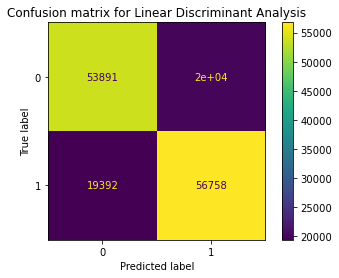

In [9]:
## Linear discriminant
modelname = "Linear discriminant"
linear_da = LinearDiscriminantAnalysis()
linear_da.fit(X_train, y_train)
y_pred = linear_da.predict(X_val)
acc_linear_da = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_linear_da)

# create confusion matrix
metrics.plot_confusion_matrix(linear_da, X_val, y_val)
plt.title("Confusion matrix for Linear Discriminant Analysis")
plt.grid(False)
plt.show()

try:
    scores_df.at[modelname, "Score"] = acc_linear_da
except:
    scores_df = scores_df.append({index: modelname, "Score": acc_linear_da})

## LinearSVC

In [ ]:
# # Linear SVC
# modelname = "Linear SVC"
# linear_svc = LinearSVC()
# linear_svc.fit(X_train, y_train)
# y_pred = linear_svc.predict(X_val)
# acc_linear_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
# print(acc_linear_svc)

# # create confusion matrix
# metrics.plot_confusion_matrix(linear_svc, X_val, y_val)
# plt.title("Confusion matrix for Linear svc")
# plt.grid(False)
# plt.show()

# try:
#     scores_df.at[modelname, "Score"] = acc_linear_svc
# except:
#     scores_df = scores_df.append({index: modelname, "Score": acc_linear_svc})

## Logistic Regression

50.77


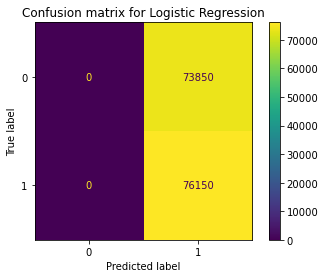

In [12]:
# Logistic Regression
modelname = "Logistic Regression"
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_val)
acc_logreg = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_logreg)

# create confusion matrix
metrics.plot_confusion_matrix(logreg, X_val, y_val)
plt.title("Confusion matrix for Logistic Regression")
plt.grid(False)
plt.show()

try:
    scores_df.at[modelname, "Score"] = acc_logreg
except:
    scores_df = scores_df.append({index: modelname, "Score": acc_logreg})

## MLP

In [ ]:
# ## MLP
# modelname = "MLP"
# MLP = MLPClassifier()
# MLP.fit(X_train, y_train)
# y_pred = MLP.predict(X_val)
# acc_MLP = round(accuracy_score(y_pred, y_val) * 100, 2)
# print(acc_MLP)

# # create confusion matrix
# metrics.plot_confusion_matrix(MLP, X_val, y_val)
# plt.title("Confusion matrix for MLP")
# plt.grid(False)
# plt.show()

# try:
#     scores_df.at[modelname, "Score"] = acc_MLP
# except:
#     scores_df = scores_df.append({index: modelname, "Score": acc_MLP})

## Passive Aggressive

In [ ]:
# ## passive aggressive
# modelname = "Passive Aggressive"
# passiveaggressive = PassiveAggressiveClassifier()
# passiveaggressive.fit(X_train, y_train)
# y_pred = passiveaggressive.predict(X_val)
# acc_passiveaggressive = round(accuracy_score(y_pred, y_val) * 100, 2)
# print(acc_passiveaggressive)

# # create confusion matrix
# metrics.plot_confusion_matrix(passiveaggressive, X_val, y_val)
# plt.title("Confusion matrix for Passive Aggressive")
# plt.grid(False)
# plt.show()

# try:
#     scores_df.at[modelname, "Score"] = acc_passiveaggressive
# except:
#     scores_df = scores_df.append(
#         {index: modelname, "Score": acc_passiveaggressive}
#     )

## Perceptron

In [ ]:
# # Perceptron
# modelname = "Perceptron"
# perceptron = Perceptron()
# perceptron.fit(X_train, y_train)
# y_pred = perceptron.predict(X_val)
# acc_perceptron = round(accuracy_score(y_pred, y_val) * 100, 2)
# print(acc_perceptron)

# # create confusion matrix
# metrics.plot_confusion_matrix(perceptron, X_val, y_val)
# plt.title("Confusion matrix for Perceptron")
# plt.grid(False)
# plt.show()

# try:
#     scores_df.at[modelname, "Score"] = acc_perceptron
# except:
#     scores_df = scores_df.append({index: modelname, "Score": acc_perceptron})

## Random Forest

In [ ]:
# Random Forest
modelname = "Random Forest"
randomforest = RandomForestClassifier(random_state=0)
randomforest.fit(X_train, y_train)
y_pred = randomforest.predict(X_val)
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_randomforest)

# create confusion matrix
metrics.plot_confusion_matrix(randomforest, X_val, y_val)
plt.title("Confusion matrix for Random Forest")
plt.grid(False)
plt.show()

try:
    scores_df.at[modelname, "Score"] = acc_randomforest
except:
    scores_df = scores_df.append({index: modelname, "Score": acc_randomforest})

## Ridge Classifier¶

In [ ]:
# ## ridge
# modelname = "Ridge"
# ridge = RidgeClassifierCV()
# ridge.fit(X_train, y_train)
# y_pred = ridge.predict(X_val)
# acc_ridge = round(accuracy_score(y_pred, y_val) * 100, 2)
# print(acc_ridge)

# # create confusion matrix
# metrics.plot_confusion_matrix(ridge, X_val, y_val)
# plt.title("Confusion matrix for Ridge")
# plt.grid(False)
# plt.show()

# try:
#     scores_df.at[modelname, "Score"] = acc_ridge
# except:
#     scores_df = scores_df.append({index: modelname, "Score": acc_ridge})

## Stochastic Gradient Descent¶

In [ ]:
# # Stochastic Gradient Descent
# modelname = "Stochastic Gradient Descent"
# sgd = SGDClassifier()
# sgd.fit(X_train, y_train)
# y_pred = sgd.predict(X_val)
# acc_sgd = round(accuracy_score(y_pred, y_val) * 100, 2)
# print(acc_sgd)

# # create confusion matrix
# metrics.plot_confusion_matrix(sgd, X_val, y_val)
# plt.title("Confusion matrix for Stochastic Gradient Descent")
# plt.grid(False)
# plt.show()

# try:
#     scores_df.at[modelname, "Score"] = acc_sgd
# except:
#     scores_df = scores_df.append({index: modelname, "Score": acc_sgd})

## Support Vector Machines

In [ ]:
# # instantiate model
# modelname = "Support Vector Machines"
# svc = SVC()
# svc.fit(X_train, y_train)
# y_pred = svc.predict(X_val)
# acc_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
# print(acc_svc)

# # create confusion matrix
# metrics.plot_confusion_matrix(svc, X_val, y_val)
# plt.title("Confusion matrix for Support Vector Machines")
# plt.grid(False)
# plt.show()

# try:
#     scores_df.at[modelname, "Score"] = acc_svc
# except:
#     scores_df = scores_df.append({index: modelname, "Score": acc_svc})

## xgboost

In [ ]:
# xgboost
modelname = "XGBoost"
xgb = XGBClassifier(n_estimators=10)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)
acc_xgb = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_xgb)

# create confusion matrix
metrics.plot_confusion_matrix(xgb, X_val, y_val)
plt.title("Confusion matrix for XGBoost")
plt.grid(False)
plt.show()

try:
    scores_df.at[modelname, "Score"] = acc_xgb
except:
    scores_df = scores_df.append({index: modelname, "Score": acc_xgb})

In [ ]:
# print(cpu_stats())

# Model Comparison

In [ ]:
# order and print model comparison
scores_df = scores_df.sort_values(by="Score", ascending=False)
print(scores_df)

# plot results
x_pos = [i for i, _ in enumerate(scores_df.index)]
plt.bar(x_pos, scores_df.Score)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Basic Model Comparison")
plt.xticks(x_pos, scores_df.index, rotation="vertical")
plt.show()

scores_f = os.path.join(drive_path, f"{scaler}_scores_{now()}.csv")
scaler = type(scaler).__name__

scores_df.to_csv(os.path.join(scores_f))
# print("Comparison saved as csv")

In [ ]:
type(scaler).__name__

## Observations on Model comparison

We fitted and scored 20 models using the default perameters, we used only 15% of the available training data and we didn't use cross fold validation in any form. (The observations below were made based on the standard scaler).

We used ROC AUC or Area Under the Receiver Operating Characteristic Curve to score the results. 

The ROC AUC scores fell into 2 groups clustered around 76 and 50. The Boosted classifiers generally produced the best results with Catboost coming top by a small margin. Ridge, Linear Discriminant Analysis and Random forest were also in the higher scoring model. Low scoring models included Gausian naive bayes, k nearest neighbour, linear svc, logistic regression, Stochastic Gradient Descent and passive aggressive models.

Many of the models that scored only around 50% prediced almost all of their vales as 0, Stochastic Gradient Descent did the opoosite and predicting all 1's.

If we take just features with higher correlations (+/-) 0.2 and run the same models agian, we get a range af ROC_AUC scores of between 49.95 and 55. The boosting models still perform best but this time only the Gaussian Naive Bayes predicts all 0's and the models at the lower end of the scale scored modertly better.

If we take just the categorical features and run the same models we get a range af ROC_AUC scores of between 61.93 and 75.77 in fact 12 of the models produce a score of 75.77.  

If we take just the continuous features and run the models we get a range of ROC_AUC scores of between 49.5 and 63.4, meaning that despite 85% of the features being contimuous on only 15% binary categogical features, the categorical features seem to produce better results than the continuous and the best categogical is only 1.5 benind the best result for all features. Once again boosters worked best.

Moving forward to data engineering and parameter tuning it would be worth initially looking at the top 8 models all of which scored around 76. It would also be worth looking at the continuous data and seeing how it could be made to produce better results. 

Now that we know which models are the most likely candidates for tuning we could rerun those models with a higher split of the available training data. We could also filter the features and try just the categorical features or just the continuous features to see how that affects the results.


## Credit were credits due

First up thanks to the Kaggle team for the tireless work putting the tabular plaground together. Many thanks to the kaggle and stackoverflow communities and the folks that contitbutor to the various documents for the various python modules, without whom finding solutions to these problems would be so much rougher.

I didn't copy any of the code in this notebook so there's no one to credit this time around, i did however copy the descriptions of each of the classifiers from the libraries online documentation pages so lots of credit to all the people that but in time to develop libraries/modules and thier supporting documents.

If you found by notebook useful or you have comments please upvote / comment here.